In [134]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss, roc_auc_score

pd.set_option("display.max_columns",150)


#### Data preprocessing

Load and preview the data

In [105]:
all_data = pd.read_csv("telco-customer-churn.csv")

print (all_data.shape)

for col_name in all_data.columns.values:
    all_unique = all_data[col_name].unique()
    print (col_name, len(all_unique), all_unique[0:5])

(20468, 29)
age 68 [12 42 58 20 36]
annualincome 9508 [168147  29047  27076 137977 136006]
calldroprate 8 [ 0.06  0.05  0.07  0.    0.01]
callfailurerate 4 [ 0.    0.01  0.02  0.03]
callingnum 9525 [4251078442 4251043419 4251055773 4251042488 4251073177]
customerid 9525 [1 2 3 4 5]
customersuspended 2 ['Yes' 'No']
education 4 ['Bachelor or equivalent' 'Master or equivalent' 'PhD or equivalent'
 'High School or below']
gender 2 ['Male' 'Female']
homeowner 2 ['Yes' 'No']
maritalstatus 2 ['Single' 'Married']
monthlybilledamount 120 [71  8 16 74 81]
noadditionallines 1 ['\\N']
numberofcomplaints 4 [0 1 3 2]
numberofmonthunpaid 8 [7 4 2 5 0]
numdayscontractequipmentplanexpiring 100 [96 14 55 73 32]
occupation 3 ['Technology Related Job' 'Non-technology Related Job' 'Others']
penaltytoswitch 500 [371  43 403  76 436]
state 50 ['WA' 'WI' 'KS' 'KY' 'ND']
totalminsusedinlastmonth 500 [ 15 212 216 412 416]
unpaidbalance 250 [ 19  34 144 159 143]
usesinternetservice 2 ['No' 'Yes']
usesvoiceservic

In [106]:
def plot_col (col_name):
    try:
        dt_plot = all_data.groupby(col_name).agg({'age':'count', 'churn': 'sum'}).reset_index().rename(columns={'age':'rec_count'})
    except: ## for age column
        dt_plot = all_data.groupby(col_name).agg({'annualincome':'count', 'churn': 'sum'}).reset_index().rename(columns={'annualincome':'rec_count'})
        
    ## for string columns
    if type(dt_plot[col_name][0]) is str:
        aa = LabelEncoder()
        dt_plot[col_name] = aa.fit_transform(dt_plot[col_name])
        
    dt_plot['churn_perc'] = dt_plot['churn'] / dt_plot['rec_count']
    print (dt_plot.head())

    plt.plot(dt_plot[col_name],dt_plot['churn_perc'])
    plt.show()


   education  rec_count  churn  churn_perc
0          0       6138    599    0.097589
1          1      10217    934    0.091416
2          2       3099    226    0.072927
3          3       1014    104    0.102564


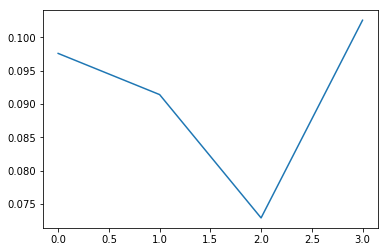

In [107]:
plot_col('education')

Удаляем колонки с годом, месяцев и номером телефона. Они не должны влиять на уровень churn. Но будем иметь в виду, что данные для каждого номера даны за несколько месяцев.

In [108]:
all_data.drop(['year','month','callingnum','customerid','noadditionallines'],axis=1,inplace=True)

Обрабатываем бинарные переменные

In [109]:
bin_cols = ['customersuspended','gender','homeowner','maritalstatus','usesinternetservice','usesvoiceservice']
for col_name in bin_cols:
    unique_val = all_data[col_name].unique()[0]
    all_data[col_name+"__"+unique_val] = 0
    all_data.loc[all_data[col_name]==unique_val,col_name+"__"+unique_val] = 1
    all_data.drop(col_name, axis = 1, inplace=True)

Обрабатываем остальные категорийные переменные

In [110]:
cd_cols = ['education','occupation','state']
all_data_cat = []
for col_name in cd_cols:
    aa = pd.get_dummies(all_data[col_name])
    aa.columns = [col_name+"__"+x for x in aa.columns.values]
    all_data_cat.append(aa)
all_data_cat = pd.concat(all_data_cat,axis=1)

In [111]:
all_data.drop(['education','occupation','state'],axis=1,inplace=True)
all_data = pd.concat([all_data,all_data_cat],axis=1)
print (all_data.shape)

(20468, 78)


#### Create model

In [121]:
X = all_data.drop('churn',axis=1).copy(deep=True)
y = np.array(all_data['churn'])

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.30, random_state=101,shuffle=True)
kf = KFold(n_splits=4,random_state=102)

print (np.sum(y),np.sum(y_train),np.sum(y_valid))

1863 1295 568


ridge regression

In [133]:
rdg = Ridge(alpha=1.0, fit_intercept=True, normalize = False, max_iter = 10)
cv_score = cross_val_score(rdg, X_train, y_train, cv = kf, n_jobs = -1, scoring = 'roc_auc')

print (cv_score, np.mean(cv_score))

[ 0.63670767  0.66326804  0.62788494  0.66300256] 0.647715803131


In [140]:
et_clf = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy',max_depth=None,
                              min_samples_leaf = 1, random_state = 103, n_jobs=-1)

et_clf.fit(X_train,y_train)

y_pred = et_clf.predict_proba(X_valid)
y_pred = [x[1] for x in y_pred]
print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,y_pred))
print ("Neg log loss: %f " % log_loss(y_valid,y_pred))


ROC AUC: 0.973622 
Neg log loss: 0.095319 


In [143]:
importances = et_clf.feature_importances_
indices = np.argsort(importances[::-1])

tree_cols = X_train.columns.values[indices]
for k, indx in enumerate(indices[:30]):
    print ("%d. feature %s (%f)" % (k,X))

array([ 4, 48, 21, 40, 32, 19, 35, 27, 36,  5, 25, 43, 28, 17,  8, 41, 23,
       14, 29, 49, 47, 11, 13, 24, 18, 42,  1, 62,  2, 30, 15, 26,  7, 31,
        6, 37, 34, 46, 22, 10,  3, 12, 38, 16, 45, 44, 33,  9,  0, 39, 20,
       53, 58, 54, 57, 52, 50, 56, 64, 51, 55, 63, 60, 59, 61, 73, 71, 74,
       70, 68, 69, 75, 72, 65, 67, 66, 76], dtype=int64)